# Packages and ngspice setup

In [24]:
import numpy as np
import matplotlib.pyplot as plt

!sudo apt-get install ngspice libngspice0

# Create a symbolic link for libngspice.so if it doesn't exist
# This is often needed because PySpice looks for libngspice.so (without the version number)
!if [ ! -f /usr/lib/x86_64-linux-gnu/libngspice.so ]; then \
    sudo ln -s /usr/lib/x86_64-linux-gnu/libngspice.so.0 /usr/lib/x86_64-linux-gnu/libngspice.so; \
    echo "Created symlink /usr/lib/x86_64-linux-gnu/libngspice.so"; \
fi

# Set the environment variable for PySpice to find ngspice
import os
os.environ['PYSPICE_NGSPICE_PATH'] = '/usr/lib/x86_64-linux-gnu/libngspice.so.0'

!pip install PySpice

# Diagnostic: Find the actual path of libngspice.so
# Please share the output of this command after execution.
!dpkg -L ngspice
!dpkg -L libngspice0

# Further Diagnostics: Check file existence and dependencies
!ls -l /usr/lib/x86_64-linux-gnu/libngspice.so
!ldd /usr/lib/x86_64-linux-gnu/libngspice.so

import PySpice.Logging.Logging as Logging
import logging # Import the standard logging module
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
import re
import torch
import scipy.signal as signal
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import concurrent.futures
import multiprocessing
import random
import glob

# Suppress specific PySpice warnings
logger = Logging.setup_logging()
logger.setLevel(logging.ERROR) # Use logging.ERROR instead of Logging.ERROR


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libngspice0 is already the newest version (36+ds-1ubuntu0.1).
ngspice is already the newest version (36+ds-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
/.
/usr
/usr/bin
/usr/bin/ngspice
/usr/lib
/usr/lib/x86_64-linux-gnu
/usr/lib/x86_64-linux-gnu/ngspice
/usr/lib/x86_64-linux-gnu/ngspice/analog.cm
/usr/lib/x86_64-linux-gnu/ngspice/digital.cm
/usr/lib/x86_64-linux-gnu/ngspice/spice2poly.cm
/usr/lib/x86_64-linux-gnu/ngspice/table.cm
/usr/lib/x86_64-linux-gnu/ngspice/xtradev.cm
/usr/lib/x86_64-linux-gnu/ngspice/xtraevt.cm
/usr/share
/usr/share/doc
/usr/share/doc/ngspice
/usr/share/doc/ngspice/BUGS
/usr/share/doc/ngspice/FAQ.gz
/usr/share/doc/ngspice/NEWS.gz
/usr/share/doc/ngspice/README
/usr/share/doc/ngspice/README.adms
/usr/share/doc/ngspice/README.optran
/usr/share/doc/ngspice/changelog.Debian.gz
/usr/share/doc/ngspice/contrib
/usr/share/doc/ngspice/contrib/sp

# Netlist Processor (SPICE)

In [25]:
class NetlistProcessor:
    """
    Motor de análisis de Netlists para el Kaspix Omni-Pipeline.
    Encargado de parsear, validar y extraer la configuración paramétrica
    de circuitos SPICE estándar.
    """

    def __init__(self, file_path):
        self.file_path = file_path
        self.content = ""
        self.params_raw = {}      # Diccionario original (texto, ej: '10k')
        self.params_float = {}    # Diccionario numérico (float, ej: 10000.0)
        self.io_config = {        # Metadatos de entrada/salida
            "input_source": None,
            "output_node": None,
            "ground_check": False
        }
        self.is_parsed = False

        # Carga inmediata
        self._load_file()

    def _load_file(self):
        if not os.path.exists(self.file_path):
            raise FileNotFoundError(f"[Kaspix Error] No se encuentra el archivo: {self.file_path}")

        with open(self.file_path, 'r', encoding='utf-8') as f:
            self.content = f.read()

    def _spice_to_float(self, value_str):
        """
        Convierte sufijos de ingeniería SPICE a float de Python.
        Soporta: T, G, Meg, k, m, u, n, p, f
        """
        value_str = value_str.lower().strip('{} ') # Limpiar llaves y espacios

        # Mapa de multiplicadores SPICE
        suffixes = {
            't': 1e12, 'g': 1e9, 'meg': 1e6, 'k': 1e3,
            'mil': 25.4e-6, 'm': 1e-3, 'u': 1e-6,
            'n': 1e-9, 'p': 1e-12, 'f': 1e-15
        }

        # Regex para separar número y sufijo
        # Busca un número (int o float) seguido opcionalmente de letras
        match = re.match(r'^([\d\.\-\+]+)([a-z]*)$', value_str)

        if not match:
            try:
                return float(value_str) # Intento directo
            except ValueError:
                return None # No es un número parseable (ej: una fórmula compleja)

        number, suffix = match.groups()
        multiplier = 1.0

        if suffix:
            # SPICE es 'greedy' con los sufijos, 'meg' es especial
            if suffix.startswith('meg'):
                multiplier = suffixes['meg']
            elif suffix[0] in suffixes:
                multiplier = suffixes[suffix[0]]

        return float(number) * multiplier

    def analyze(self):
        """
        Ejecuta el análisis léxico del netlist.
        """
        lines = self.content.splitlines()

        # Regex Compilados
        re_param = re.compile(r'\.param\s+(\w+)\s*=\s*(\{?[\w\.\-\+]+\}?)', re.IGNORECASE)
        re_source = re.compile(r'^\s*([vV]\w+)\s+(\w+)\s+(\w+)', re.IGNORECASE)
        re_save = re.compile(r'\.(?:save|print)\s+(?:v|tran)\s*\((.+?)\)', re.IGNORECASE)

        for line in lines:
            line = line.strip()
            if not line or line.startswith('*'): continue

            # 1. Detectar Parámetros (.param)
            pm = re_param.search(line)
            if pm:
                name, val_str = pm.groups()
                # Guardar raw
                self.params_raw[name] = val_str
                # Convertir a float
                val_float = self._spice_to_float(val_str)
                if val_float is not None:
                    self.params_float[name] = val_float

            # 2. Detectar Inputs (Heurística: Nombre contiene 'in' o 'src')
            sm = re_source.match(line)
            if sm:
                s_name, n_pos, n_neg = sm.groups()
                # Priorizamos fuentes que parezcan de señal
                if 'in' in s_name.lower() or 'src' in s_name.lower() or 'sig' in s_name.lower():
                    self.io_config["input_source"] = s_name

            # 3. Detectar Ground
            if ' 0 ' in line or line.endswith(' 0'):
                self.io_config["ground_check"] = True

            # 4. Detectar Output (.save)
            svm = re_save.search(line)
            if svm:
                # Extraer contenido dentro de paréntesis
                nodes = svm.group(1).replace(')', '').replace('(', '').split()
                if nodes:
                    self.io_config["output_node"] = nodes[0] # Tomamos el primero como principal

        # Fallback para Output si no hay .save
        if not self.io_config["output_node"]:
             if re.search(r'\b(out|output|salida)\b', self.content, re.IGNORECASE):
                 self.io_config["output_node"] = "out (Inferred)"
             else:
                 self.io_config["output_node"] = "UNKNOWN (Define .save V(node))"

        self.is_parsed = True
        return self.get_summary()

    def get_summary(self):
        if not self.is_parsed: return "No analizado."
        return {
            "file_path": self.file_path,
            "valid_spice": self.io_config["ground_check"],
            "knobs_detected": list(self.params_float.keys()),
            "knobs_values": self.params_float,
            "input_source": self.io_config["input_source"],
            "output_target": self.io_config["output_node"]
        }

# Dataset Generation

In [26]:
# ============================================================================
# 0. FUNCIONES AUXILIARES - REPRODUCIBILIDAD
# ============================================================================
def set_global_seed(seed=42):
    """
    Establece semillas aleatorias para reproducibilidad total.

    Args:
        seed: Semilla (int)
    """
    import random
    import numpy as np
    import torch

    # Python random
    random.seed(seed)

    # NumPy random
    np.random.seed(seed)

    # PyTorch random
    torch.manual_seed(seed)

    # Si usas CUDA (GPU)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # Para multi-GPU

        # Configuración para reproducibilidad CUDA (más lento pero determinista)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    print(f"✅ Kaspix Seed Locked: {seed}")

# ============================================================
# 1. KASPIX SIGNAL FACTORY (Con Dinámica de Amplitud)
# ============================================================
class KaspixSignalFactory:
    def __init__(self, fs, duration_sec):
        self.fs = fs
        self.duration = duration_sec
        self.n_samples = int(fs * duration_sec)
        self.time_axis = np.linspace(0, duration_sec, self.n_samples)

    def _apply_dynamic_gain(self, y):
        """
        Simula la variación de volumen de entrada (Dinámica).
        """
        target_peak = np.exp(np.random.uniform(np.log(0.05), np.log(1.5)))
        max_val = np.max(np.abs(y))
        if max_val > 1e-9:
            return (y / max_val) * target_peak
        return y

    def _apply_input_noise(self, signal_in):
        """
        [NUEVO] Inyecta un 'Piso de Ruido' realista.
        Simula interferencia eléctrica, térmica o de cables.
        """
        # 1. Decidir si esta muestra tendrá ruido (90% de las veces sí)
        if np.random.rand() > 0.9:
            return signal_in

        # 2. Generar Ruido Base (Blanco)
        noise = np.random.randn(len(signal_in))

        # 3. Determinar nivel de ruido (SNR)
        # Un 'Noise Floor' típico en audio va de -60dB (bueno) a -30dB (malo/vintage)
        # Calculamos la amplitud del ruido basada en una referencia fija (no relativa a la señal)
        # Esto simula que el ruido es constante independientemente de si tocas fuerte o suave.
        noise_level_db = np.random.uniform(-70, -30)
        noise_amplitude = 10 ** (noise_level_db / 20)

        # 4. Mezclar
        noisy_signal = signal_in + (noise * noise_amplitude)

        # Opcional: Recortar picos si se pasa de +/- 1.5V (Safety Clip)
        return np.clip(noisy_signal, -1.5, 1.5)

    # --- Generadores Primitivos ---
    def _pink_noise(self):
        uneven = self.n_samples % 2
        X = np.random.randn(self.n_samples // 2 + 1 + uneven) + 1j * np.random.randn(self.n_samples // 2 + 1 + uneven)
        S = np.sqrt(np.arange(len(X)) + 1.)
        y = (np.fft.irfft(X / S)).real
        if uneven: y = y[:-1]
        # ORDEN FÍSICO: Señal -> Ganancia -> Ruido de Cable
        y = self._apply_dynamic_gain(y)
        return self._apply_input_noise(y)

    def _chirp_log(self):
        f_start = 20
        f_end = np.random.uniform(self.fs/4, self.fs/2 * 0.9)
        y = signal.chirp(self.time_axis, f0=f_start, f1=f_end, t1=self.duration, method='logarithmic')
        y = self._apply_dynamic_gain(y)
        return self._apply_input_noise(y)

    def _step_sequence(self):
        num_steps = np.random.randint(3, 12)
        y = np.zeros_like(self.time_axis)
        indices = np.sort(np.random.choice(np.arange(self.n_samples), num_steps, replace=False))
        levels = np.random.uniform(-0.8, 0.8, num_steps)
        current_idx = 0
        for i, idx in enumerate(indices):
            y[current_idx:idx] = levels[i-1] if i > 0 else 0
            current_idx = idx
        y[current_idx:] = levels[-1]
        # Los steps ya tienen amplitud propia, solo añadimos ruido
        return self._apply_input_noise(y)

    def _multitone(self):
        num_tones = np.random.randint(3, 15)
        y = np.zeros_like(self.time_axis)
        for _ in range(num_tones):
            freq = np.random.uniform(20, self.fs/3)
            phase = np.random.uniform(0, 2*np.pi)
            y += np.sin(2 * np.pi * freq * self.time_axis + phase)
        y = self._apply_dynamic_gain(y)
        return self._apply_input_noise(y)

    def _impulse_train(self):
        y = np.zeros_like(self.time_axis)
        num_impulses = np.random.randint(1, 5)
        indices = np.random.randint(0, self.n_samples, num_impulses)
        y[indices] = 1.0
        # Impulsos limpios suelen ser mejores para analisis, pero ruido leve no daña
        return self._apply_input_noise(y)

    def get_signal(self, recipe):
        keys = list(recipe.keys())
        probs = np.array(list(recipe.values()))
        probs /= probs.sum()
        choice = np.random.choice(keys, p=probs)

        sig = None
        name = "Unknown"

        if choice == 'chirp':
            sig, name = self._chirp_log(), "Chirp Log"
        elif choice == 'pink_noise':
            sig, name = self._pink_noise(), "Pink Noise"
        elif choice == 'step_sequence':
            sig, name = self._step_sequence(), "Step Seq"
        elif choice == 'multitone':
            sig, name = self._multitone(), "Multitone"
        elif choice == 'impulse':
            sig, name = self._impulse_train(), "Impulse"
        elif choice == 'sine':
            f = np.random.uniform(20, 1000)
            raw = np.sin(2*np.pi*f*self.time_axis)
            sig, name = self._apply_input_noise(self._apply_dynamic_gain(raw)), f"Sine {int(f)}Hz"
        elif choice == 'silence_decay':
             raw = np.zeros_like(self.time_axis)
             raw[:int(self.n_samples*0.1)] = np.random.randn(int(self.n_samples*0.1))
             # El silencio DEBE tener ruido de fondo para ser realista
             sig, name = self._apply_input_noise(self._apply_dynamic_gain(raw)), "Silence Decay"
        else:
            sig, name = self._pink_noise(), "Default (Pink)"

        return sig, name

# ============================================================
# 2. WORKER SIMULATOR (Con soporte para Dummy Knob)
# ============================================================
def _simulation_worker(task_payload):
    import numpy as np
    import re
    from PySpice.Spice.Parser import SpiceParser

    # --- SANITIZADOR DE NETLIST (Regex) ---
    def sanitize_netlist(content):
        """
        1. Elimina espacios dentro de llaves {} para arreglar fórmulas matemáticas.
           Ej: {R * 0.5} -> {R*0.5}
        2. Mueve .subckt al inicio (por seguridad, aunque usamos VCVS fix).
        """
        # Regex para eliminar espacios SOLO dentro de llaves
        content = re.sub(r'\{([^{}]*)\}', lambda m: '{' + m.group(1).replace(' ', '') + '}', content)

        # Reordenamiento de subcircuitos
        lines = content.splitlines()
        if not lines: return content
        title = lines[0]
        body = []
        subckts = []
        in_subckt = False
        buffer = []

        for line in lines[1:]:
            l_lower = line.strip().lower()
            if l_lower.startswith('.subckt'):
                in_subckt = True
                buffer.append(line)
            elif l_lower.startswith('.ends'):
                in_subckt = False
                buffer.append(line)
                subckts.extend(buffer)
                buffer = []
            elif in_subckt:
                buffer.append(line)
            else:
                body.append(line)
        return "\n".join([title] + subckts + body)
    # --------------------------------------

    try:
        # Desempaquetado
        file_path = task_payload['file_path']
        input_source = task_payload['input_source']
        output_target = task_payload['output_target']
        fs = float(task_payload['fs'])
        duration = float(task_payload['duration'])
        input_signal = task_payload['input_signal']
        knob_config = task_payload['knob_config']
        task_id = task_payload['id']

        # 1. LEER Y SANITIZAR
        with open(file_path, 'r', encoding='utf-8') as f:
            raw_content = f.read()

        # APLICAR SANITIZACIÓN (Aquí se arregla el Notch Filter)
        clean_content = sanitize_netlist(raw_content)

        parser = SpiceParser(source=clean_content)
        circuit = parser.build_circuit()

        # --- FIX NUCLEAR: REEMPLAZO DE OPAMP X1 POR VCVS NATIVO ---
        # Detectamos subcircuitos X (OpAmps) y los cambiamos por primitivas E (VCVS)
        x_element_name = None
        for elm_name in list(circuit.element_names):
            if elm_name.upper().startswith('X'):
                x_element_name = elm_name
                break

        if x_element_name:
            x_component = circuit[x_element_name]
            # Asumimos orden standard: non_inv, inv, out
            if len(x_component.nodes) >= 3:
                node_non_inv = x_component.nodes[0]
                node_inv     = x_component.nodes[1]
                node_out     = x_component.nodes[2]

                circuit._elements.pop(x_element_name)

                # Inyectar VCVS (Fuente de voltaje controlada por voltaje)
                # Sintaxis interna: (name, node_plus, node_minus, ctl_plus, ctl_minus, gain)
                circuit.VCVS(
                    'OpAmp_Replacer',
                    node_out,
                    circuit.gnd,
                    node_non_inv,
                    node_inv,
                    voltage_gain=100000
                )

        # 2. INYECCIÓN DE FUENTE PWL
        actual_source_name = None
        for element in circuit.element_names:
            if element.upper() == input_source.upper():
                actual_source_name = element
                break

        if actual_source_name:
            original_source = circuit[actual_source_name]
            n_pos = str(original_source.nodes[0])
            n_neg = str(original_source.nodes[1])
            circuit._elements.pop(actual_source_name)

            time_axis = np.linspace(0, duration, len(input_signal))
            input_data = list(zip(
                [float(t) for t in time_axis],
                [float(v) for v in input_signal]
            ))
            circuit.PieceWiseLinearVoltageSource('Input_UES', n_pos, n_neg, values=input_data)
        else:
            return {"status": "error", "msg": f"Fuente '{input_source}' no hallada", "id": task_id}

        # 3. APLICAR KNOBS (Inyección y Sanitización)
        for name, val in knob_config.items():
            if name == 'dummy_param': continue
            val_f = float(val)

            # Inyección robusta en componentes o parámetros
            if name in circuit.element_names:
                obj = circuit[name]
                if hasattr(obj, 'resistance'): obj.resistance = val_f
                elif hasattr(obj, 'capacitance'): obj.capacitance = val_f
                elif hasattr(obj, 'inductance'): obj.inductance = val_f
                elif hasattr(obj, 'dc_value'): obj.dc_value = val_f
                elif hasattr(obj, 'voltage_gain'): obj.voltage_gain = val_f
            else:
                circuit.parameter(name, val_f)

        # 4. SIMULACIÓN
        simulator = circuit.simulator(temperature=25, nominal_temperature=25)

        try:
            step = float(1.0/fs)
            end_t = float(duration)
            analysis = simulator.transient(step_time=step, end_time=end_t)
        except Exception as e:
            return {"status": "error", "msg": f"NGSpice Crash: {str(e)}", "id": task_id}

        # 5. EXTRACCIÓN Y LIMPIEZA
        target_clean = output_target.upper().replace('V(', '').replace(')', '').strip()
        found_node = None

        # Búsqueda de nodo output
        for node_name in analysis.nodes:
            if str(node_name).upper() == target_clean:
                found_node = node_name
                break
        if found_node is None:
            for node_name in analysis.nodes:
                if str(node_name).upper() == 'OUT':
                    found_node = node_name
                    break
        # Último recurso: buscar substring 'OUT' o 'SALIDA'
        if found_node is None:
            for node_name in analysis.nodes:
                if 'OUT' in str(node_name).upper():
                    found_node = node_name
                    break

        if found_node is None:
            return {"status": "error", "msg": f"Salida '{target_clean}' no encontrada", "id": task_id}

        output_signal = np.array(analysis.nodes[found_node])

        # 6. CHEQUEOS DE SEGURIDAD
        if np.isnan(output_signal).any():
            return {"status": "error", "msg": "NaN Detectado", "id": task_id}
        if np.max(np.abs(output_signal)) > 200:
            return {"status": "error", "msg": "Explosión Numérica (>200V)", "id": task_id}

        if len(output_signal) != len(time_axis):
            output_signal = np.interp(time_axis, np.array(analysis.time), output_signal)

        return {
            "status": "ok",
            "id": task_id,
            "y": output_signal.astype(np.float32),
            "x_meta": {
                "knobs": np.array(list(knob_config.values()), dtype=np.float32),
                "knob_names": list(knob_config.keys())
            }
        }

    except Exception as e:
        return {"status": "error", "msg": f"Worker Logic Fail: {str(e)}", "id": task_payload.get('id', -1)}
# ============================================================
# 3. KASPIX GENERATOR (Con inyección de Dummy Knob)
# ============================================================
class KaspixParallelGenerator:
    def __init__(self, processor_result, fs=48000, duration_sec=0.2, recipe=None, seed=42):
        self.meta = processor_result
        self.fs = fs
        self.duration = duration_sec
        self.seed = seed
        self.factory = KaspixSignalFactory(fs, duration_sec)
        self.time_axis = self.factory.time_axis
        self.recipe = recipe if recipe else {"chirp": 1.0}

        if not self.meta['valid_spice']:
            raise ValueError("[Kaspix] Netlist inválido.")

        self.max_workers = multiprocessing.cpu_count()
        print(f"⚡ Kaspix Parallel Engine V6 (Dynamic Gain + Dummy Fix): {self.max_workers} núcleos | Seed: {self.seed}")

    def _sample_knobs(self, variation_pct=0.8):
        nominal = self.meta['knobs_values']

        # [MEJORA #3] Si no hay knobs detectados, inyectar uno falso
        if not nominal:
            # Retornamos un valor fijo (ej. 1.0) para mantener la estructura FiLM
            return {'dummy_param': 1.0}

        sampled = {}
        for name, val in nominal.items():
            delta = val * variation_pct
            new_val = np.random.uniform(val - delta, val + delta)
            if new_val <= 0: new_val = val * 0.01
            sampled[name] = new_val
        return sampled

    def build_dataset(self, n_samples=100, save_path="kaspix_dataset.pt"):
        set_global_seed(self.seed)
        print(f"--- Preparando {n_samples} tareas deterministas ---")

        tasks = []
        pre_generated_signals = {}

        for i in range(n_samples):
            sig_in, sig_type = self.factory.get_signal(self.recipe)
            knobs = self._sample_knobs()

            pre_generated_signals[i] = {
                "audio_in": sig_in.astype(np.float32),
                "signal_type": sig_type
            }

            task = {
                "id": i,
                "file_path": self.meta['file_path'],
                "input_source": self.meta['input_source'],
                "output_target": self.meta['output_target'],
                "fs": self.fs,
                "duration": self.duration,
                "input_signal": sig_in,
                "knob_config": knobs
            }
            tasks.append(task)

        print(f"🚀 Procesando...")
        results_unsorted = []
        with concurrent.futures.ProcessPoolExecutor(max_workers=self.max_workers) as executor:
            results_unsorted = list(tqdm(executor.map(_simulation_worker, tasks), total=n_samples))

        print("📦 Ordenando y verificando consistencia...")
        results_sorted = sorted(results_unsorted, key=lambda x: x['id'])

        dataset_x = []
        dataset_y = []
        success_count = 0

        for res in results_sorted:
            idx = res['id']
            if res['status'] == 'ok':
                input_meta = pre_generated_signals[idx]
                worker_meta = res['x_meta']
                x_entry = {
                    "audio_in": input_meta['audio_in'],
                    "signal_type": input_meta['signal_type'],
                    "knobs": worker_meta['knobs'],
                    "knob_names": worker_meta['knob_names']
                }
                dataset_x.append(x_entry)
                dataset_y.append(res['y'])
                success_count += 1
            else:
                if success_count == 0:
                    print(f"❌ Error en muestra {idx}: {res['msg']}")

        if success_count == 0:
            print("❌ FALLO TOTAL.")
            return [], []

        print(f"💾 Guardando {success_count}/{n_samples} muestras en {save_path}...")
        torch.save({
            "x": dataset_x,
            "y": dataset_y,
            "fs": self.fs,
            "meta": self.meta,
            "recipe": self.recipe,
            "seed": self.seed
        }, save_path)

        return dataset_x, dataset_y

# Execution

In [29]:
# ============================================================
# BLOQUE PRINCIPAL DE EJECUCIÓN (KASPIX OMNI-PIPELINE V4.2)
# ============================================================
if __name__ == "__main__":
    # 1. CONFIGURACIÓN GLOBAL Y RUTAS
    # ------------------------------------------------------------
    CIRCUITS_DIR = "circuits"
    CIRCUITS_DIR = "circuits_old_but_working"
    DATA_DIR = "datasets"
    OUTPUT_DATASET = "kaspix_full_dataset.pt"

    os.makedirs(DATA_DIR, exist_ok=True)

    N_SAMPLES_PER_NETLIST = 50
    SAMPLE_RATE = 48000
    DURATION = 0.04

    RECIPE_MIX = {
        "chirp": 0.25, "pink_noise": 0.20, "multitone": 0.15,
        "step_sequence": 0.20, "sine": 0.10, "impulse": 0.05,
        "silence_decay": 0.05
    }

    netlist_files = sorted(glob.glob(os.path.join(CIRCUITS_DIR, "*.cir")))

    if not netlist_files:
        print(f"❌ ERROR: No se encontraron archivos .cir en '{CIRCUITS_DIR}'")
        exit(1)

    # --- MAPEO GENÉRICO DE IDs ---
    # Creamos un diccionario para que cada archivo tenga un ID único fijo
    circuit_mapping = {os.path.basename(f): i for i, f in enumerate(netlist_files)}

    all_data_x = []
    all_data_y = []

    print(f"🚀 INICIANDO KASPIX OMNI-PIPELINE MULTI-NETLIST")
    print(f"🆔 Mapeo de Circuitos: {circuit_mapping}")

    # 2. BUCLE DE PROCESAMIENTO
    # ------------------------------------------------------------
    for target_netlist in netlist_files:
        netlist_name = os.path.basename(target_netlist)
        current_id = circuit_mapping[netlist_name]

        print(f"\n--- Procesando ID {current_id}: {netlist_name} ---")

        processor = NetlistProcessor(target_netlist)
        circuit_meta = processor.analyze()

        if not circuit_meta['valid_spice']:
            continue

        generator = KaspixParallelGenerator(
            processor_result=circuit_meta,
            fs=SAMPLE_RATE,
            duration_sec=DURATION,
            recipe=RECIPE_MIX
        )

        dx, dy = generator.build_dataset(
            n_samples=N_SAMPLES_PER_NETLIST,
            save_path=os.path.join(DATA_DIR, f"temp_{netlist_name}_dataset.pt")
        )

        # Inyectamos metadatos genéricos en cada muestra
        for sample in dx:
            sample['netlist_origin'] = netlist_name
            sample['circuit_id'] = current_id  # <--- ID NUMÉRICO PARA LA RED
            sample['knob_names'] = list(circuit_meta['knobs_values'].keys())

        all_data_x.extend(dx)
        all_data_y.extend(dy)

    # 3. GUARDADO CONSOLIDADO
    # ------------------------------------------------------------
    save_path = os.path.join(DATA_DIR, OUTPUT_DATASET)
    print(f"\n[Final] Consolidando {len(all_data_x)} muestras...")

    torch.save({
        'x': all_data_x,
        'y': all_data_y,
        'metadata': {
            'fs': SAMPLE_RATE,
            'recipe': RECIPE_MIX,
            'n_samples_per_netlist': N_SAMPLES_PER_NETLIST,
            'duration': DURATION,
            'netlist_names': netlist_files,
            'circuit_mapping': circuit_mapping,
            'n_samples_total': len(all_data_x)
        }
    }, save_path)

    print(f"✅ Dataset maestro guardado en: {save_path}")

🚀 INICIANDO KASPIX OMNI-PIPELINE MULTI-NETLIST
🆔 Mapeo de Circuitos: {'active_bandpass_mfb.cir': 0, 'active_notch_twint.cir': 1, 'sallen_key_hpf.cir': 2, 'sallen_key_lpf.cir': 3}

--- Procesando ID 0: active_bandpass_mfb.cir ---
⚡ Kaspix Parallel Engine V6 (Dynamic Gain + Dummy Fix): 2 núcleos | Seed: 42
✅ Kaspix Seed Locked: 42
--- Preparando 50 tareas deterministas ---
🚀 Procesando...


100%|██████████| 50/50 [00:10<00:00,  4.78it/s]

📦 Ordenando y verificando consistencia...
💾 Guardando 50/50 muestras en datasets/temp_active_bandpass_mfb.cir_dataset.pt...

--- Procesando ID 1: active_notch_twint.cir ---
⚡ Kaspix Parallel Engine V6 (Dynamic Gain + Dummy Fix): 2 núcleos | Seed: 42
✅ Kaspix Seed Locked: 42
--- Preparando 50 tareas deterministas ---
🚀 Procesando...



 70%|███████   | 35/50 [00:09<00:03,  3.85it/s]

2026-01-28 19:25:08,686 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - ERROR - doAnalyses: TRAN:  Timestep too small; time = 0.0304153, timestep = 2.60417e-17: cause unrecorded.
2026-01-28 19:25:08,696 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - ERROR - run simulation(s) aborted


 94%|█████████▍| 47/50 [00:13<00:01,  2.97it/s]

2026-01-28 19:25:11,961 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - ERROR - doAnalyses: TRAN:  Timestep too small; time = 0.0257256, timestep = 2.60417e-17: cause unrecorded.
2026-01-28 19:25:11,969 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - ERROR - run simulation(s) aborted


100%|██████████| 50/50 [00:13<00:00,  3.60it/s]

📦 Ordenando y verificando consistencia...
❌ Error en muestra 0: Explosión Numérica (>200V)
💾 Guardando 35/50 muestras en datasets/temp_active_notch_twint.cir_dataset.pt...

--- Procesando ID 2: sallen_key_hpf.cir ---
⚡ Kaspix Parallel Engine V6 (Dynamic Gain + Dummy Fix): 2 núcleos | Seed: 42
✅ Kaspix Seed Locked: 42
--- Preparando 50 tareas deterministas ---
🚀 Procesando...



100%|██████████| 50/50 [00:12<00:00,  4.14it/s]


📦 Ordenando y verificando consistencia...
💾 Guardando 50/50 muestras en datasets/temp_sallen_key_hpf.cir_dataset.pt...

--- Procesando ID 3: sallen_key_lpf.cir ---
⚡ Kaspix Parallel Engine V6 (Dynamic Gain + Dummy Fix): 2 núcleos | Seed: 42
✅ Kaspix Seed Locked: 42
--- Preparando 50 tareas deterministas ---
🚀 Procesando...


100%|██████████| 50/50 [00:12<00:00,  4.07it/s]


📦 Ordenando y verificando consistencia...
💾 Guardando 50/50 muestras en datasets/temp_sallen_key_lpf.cir_dataset.pt...

[Final] Consolidando 185 muestras...
✅ Dataset maestro guardado en: datasets/kaspix_full_dataset.pt


📦 Dataset cargado correctamente: 185 muestras de audio.


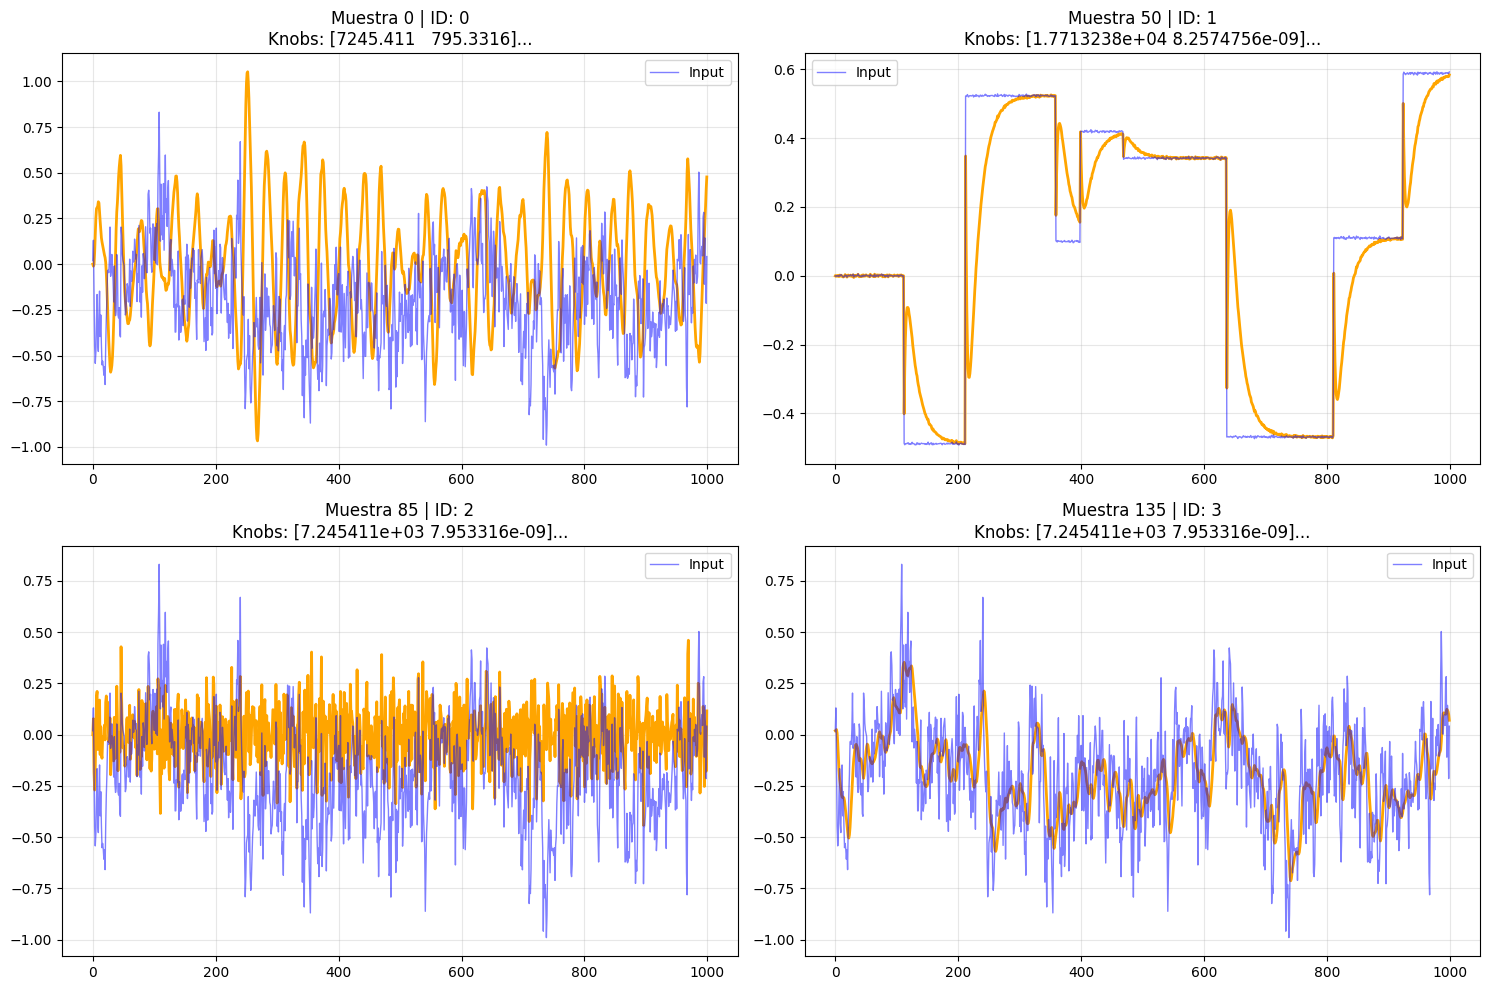


--- Estructura Real de una Muestra (x) ---
dict_keys(['audio_in', 'signal_type', 'knobs', 'knob_names', 'netlist_origin', 'circuit_id'])


In [31]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 1. Cargar el diccionario
dataset_path = 'datasets/kaspix_full_dataset.pt'
data_dict = torch.load(dataset_path, weights_only=False)

# Extraer las listas reales
dataset_x = data_dict['x']
dataset_y = data_dict['y']

print(f"📦 Dataset cargado correctamente: {len(dataset_x)} muestras de audio.")

# 2. Inspección Visual
plt.figure(figsize=(15, 10))
found_types = []

# Iteramos sobre la lista 'dataset_x' usando índice
for i in range(len(dataset_x)):
    sample_x = dataset_x[i]
    sample_y = dataset_y[i]

    # IMPORTANTE: Verificamos qué llave tiene el ID.
    # Si la consolidación añadió el ID, suele ser 'circuit_id', 'topology_id' o 'id'
    # Probamos suerte:
    c_id = sample_x.get('circuit_id', sample_x.get('id', -1))

    # Si no hay ID en la muestra, usamos un placeholder para graficar igual
    if c_id == -1:
        c_id = f"Unknown (Idx {i})"

    # Solo graficamos uno de cada tipo (si tenemos ID) o los primeros 4
    if c_id not in found_types or c_id == -1:
        if c_id != -1: found_types.append(c_id)

        idx = len(found_types) + (1 if c_id == -1 else 0)
        if idx > 4: break # Solo 4 plots

        knobs = sample_x['knobs']

        plt.subplot(2, 2, idx)
        plt.plot(sample_y[:1000], linewidth=2, color='orange') # Primeros 1000 puntos
        plt.plot(sample_x['audio_in'][:1000], linewidth=1, alpha=0.5, color='blue', label='Input')
        plt.title(f"Muestra {i} | ID: {c_id}\nKnobs: {knobs[:2]}...")
        plt.legend()
        plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Chivato de Tensores
print("\n--- Estructura Real de una Muestra (x) ---")
print(dataset_x[0].keys())

# How to load data (FiLM) and Parameter Statistics

In [32]:
import torch
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader

class KaspixDatasetFiLM(Dataset):
    def __init__(self, pt_file_path):
        print(f"📂 Cargando Dataset FiLM desde: {pt_file_path}")

        loaded = torch.load(pt_file_path, weights_only=False)
        self.data_x = loaded['x']
        self.data_y = loaded['y']
        self.meta = loaded['metadata']

        # --- SOLUCIÓN AL ERROR DE FORMA (PADDING) ---
        # 1. Encontrar el número máximo de knobs en cualquier circuito
        self.max_knobs = max(len(item['knobs']) for item in self.data_x)

        # 2. Crear una matriz de ceros y llenarla con los knobs existentes
        # Usamos NaNs temporalmente para que el min/max no se vea afectado por el relleno de ceros
        all_knobs_padded = np.full((len(self.data_x), self.max_knobs), np.nan)

        for i, item in enumerate(self.data_x):
            k = item['knobs']
            all_knobs_padded[i, :len(k)] = k

        # 3. Calcular estadísticas ignorando los NaNs
        self.k_min = torch.from_numpy(np.nanmin(all_knobs_padded, axis=0)).float()
        self.k_max = torch.from_numpy(np.nanmax(all_knobs_padded, axis=0)).float()

        # Evitar división por cero
        self.k_max[self.k_max == self.k_min] += 1e-6

        # 4. Sustituir NaNs por 0 para el procesamiento final
        self.all_knobs_fixed = np.nan_to_num(all_knobs_padded, nan=0.0)

        print(f"✅ Dataset Cargado: {len(self.data_x)} muestras.")
        print(f"   -> Máximo de Knobs detectado: {self.max_knobs}")
        print(f"   -> Mapeo de circuitos: {self.meta['circuit_mapping']}")

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        # A. Audio Input [1, L]
        audio_raw = self.data_x[idx]['audio_in']
        x_audio = torch.from_numpy(audio_raw).float().unsqueeze(0)

        # B. Knobs con Padding y Normalización [max_knobs]
        knobs_raw = torch.from_numpy(self.all_knobs_fixed[idx]).float()
        x_knobs_norm = (knobs_raw - self.k_min) / (self.k_max - self.k_min)
        # Asegurar que el relleno de ceros siga siendo cero tras la normalización
        x_knobs_norm = torch.nan_to_num(x_knobs_norm, nan=0.0)

        # C. Circuit ID (¡Nuevo!)
        # Lo devolvemos como un long tensor para usarlo en capas de Embedding
        circuit_id = torch.tensor(self.data_x[idx]['circuit_id']).long()

        # D. Target Audio [1, L]
        target_raw = self.data_y[idx]
        y_target = torch.from_numpy(target_raw).float().unsqueeze(0)

        return x_audio, x_knobs_norm, circuit_id, y_target

# ============================================================
# BLOQUE DE PRUEBA ACTUALIZADO (Unpack de 4 valores)
# ============================================================
if __name__ == "__main__":
    # Asegúrate de que la ruta coincida con tu carpeta de datasets
    ds = KaspixDatasetFiLM("datasets/kaspix_full_dataset.pt")
    dl = DataLoader(ds, batch_size=4, shuffle=True)

    # Ahora desempaquetamos 4 valores: Audio, Knobs, ID, Target
    b_audio, b_knobs, b_ids, b_target = next(iter(dl))

    print("\n--- INSPECCIÓN DE TENSOR (Omni-Pipeline V4.2) ---")
    print(f"1. Audio Input Shape:  {b_audio.shape}")   # (Batch, 1, Time)
    print(f"2. Knobs (Padded):     {b_knobs.shape}")   # (Batch, max_knobs)
    print(f"3. Circuit IDs:        {b_ids.tolist()}")  # Lista de IDs en el batch
    print(f"4. Target Shape:       {b_target.shape}")

    # Ejemplo detallado de la primera muestra del batch
    print(f"\nEjemplo Muestra #0:")
    id_actual = b_ids[0].item()
    # Invertimos el mapping para saber el nombre
    nombres = {v: k for k, v in ds.meta['circuit_mapping'].items()}
    print(f"   Tipo de Filtro: {nombres[id_actual]} (ID: {id_actual})")
    print(f"   Knobs Norm:     {b_knobs[0].numpy()}")

📂 Cargando Dataset FiLM desde: datasets/kaspix_full_dataset.pt
✅ Dataset Cargado: 185 muestras.
   -> Máximo de Knobs detectado: 5
   -> Mapeo de circuitos: {'active_bandpass_mfb.cir': 0, 'active_notch_twint.cir': 1, 'sallen_key_hpf.cir': 2, 'sallen_key_lpf.cir': 3}

--- INSPECCIÓN DE TENSOR (Omni-Pipeline V4.2) ---
1. Audio Input Shape:  torch.Size([4, 1, 1920])
2. Knobs (Padded):     torch.Size([4, 5])
3. Circuit IDs:        [0, 2, 0, 0]
4. Target Shape:       torch.Size([4, 1, 1920])

Ejemplo Muestra #0:
   Tipo de Filtro: active_bandpass_mfb.cir (ID: 0)
   Knobs Norm:     [0.11562544 0.78490365 0.         0.         0.        ]
